#코랩에서는 실시간 웹캠을 지원하지않으므로, 다른 Tool에서 사용해야합니다

#프로젝트 소개


이 프로젝트는 최근 다양한 분야에서 얼굴 인식이 활용되고 있는만큼, 이 프로젝트를 통해, 사용자가 카메라 앞에서 재미있는 필터와 효과를 적용하여 즐거운 경험을 할 수 있도록 만든 코드

<주요 기능>

● 이미지 투명도 처리 (make_white_transparent 함수) : 이미지를 입력받아 흰색 픽셀을 투명하게 변환하여 오버레이 이미지에 적합한 형식으로 만듬

● 오버레이 이미지 합성 : 주어진 좌표에 오버레이 이미지를 붙여 원본 이미지와 혼합. 알파 채널을 사용하여 투명도 조절

● 웹캠에서 실시간 이미지 캡처 : OpenCV의 VideoCapture를 사용하여 웹캠에서 실시간 비디오 스트림을 캡처하고, 얼굴 검출 작업 수행

● 얼굴 검출 및 특징점 인식 : MediaPipe의 얼굴 검출 모듈을 활용하여 얼굴과 주요 특징점(눈, 코 등)을 인식하고, 이를 오버레이 이미지의 위치로 사용

● 결과 출력 및 사용자 상호작용 : 합성된 이미지를 화면에 출력하며, 'q'키를 눌러 프로그램 종료

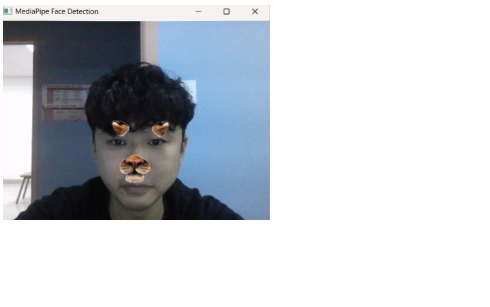

In [ ]:
import cv2
import mediapipe as mp
import numpy as np

#흰색 배경을 투명하게 변환하는 함수
def make_white_transparent(image):
    if image.shape[2] == 4:  #알파 채널이 이미 있는 경우
        b, g, r, a = cv2.split(image)
        # 흰색 영역 찾기
        mask = (b == 255) & (g == 255) & (r == 255)
        #흰색 부분을 투명으로 변경
        a[mask] = 0
        image = cv2.merge([b, g, r, a])
    else:  #알파 채널이 없는 경우 추가
        b, g, r = cv2.split(image)
        a = np.ones(b.shape, dtype=b.dtype) * 255
        mask = (b == 255) & (g == 255) & (r == 255)
        a[mask] = 0
        image = cv2.merge([b, g, r, a])
    return image

#이미지 위에 오버레이를 적용하는 함수
def overlay(image, x, y, overlay_image, scale=1.0):
    #오버레이 이미지를 입력받은 크기로 조정
    overlay_image_resized = cv2.resize(overlay_image, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

    #오버레이 이미지가 알파 채널이 있는 경우
    if overlay_image_resized.shape[2] == 4:
        alpha = overlay_image_resized[:, :, 3] / 255.0  #이미지 합성 과정에서 투명도를 정확히 계산하기 위해서 알파 채널을 0~1 사이 값으로 정규화
        overlay_image_rgb = overlay_image_resized[:, :, :3]  #RGB 채널만 분리
    else:  #알파 채널이 없는 경우
        alpha = np.ones(overlay_image_resized.shape[:2], dtype=overlay_image_resized.dtype)  #np.ones를 사용해 (높이, 너비)의 크기로 모든 값이 1인 배열을 생성하여 불투명으로 초기화
        overlay_image_rgb = overlay_image_resized

    h, w = overlay_image_rgb.shape[:2]  #오버레이 이미지의 높이와 너비 가져오기

    #이미지에서 오버레이가 적용될 영역의 좌표 계산
    start_x = max(x - w // 2, 0)
    start_y = max(y - h // 2, 0)
    end_x = min(start_x + w, image.shape[1])
    end_y = min(start_y + h, image.shape[0])

    #오버레이를 적용할 영역과 알파 값 자르기
    overlay_area = image[start_y:end_y, start_x:end_x]
    overlay_image_cropped = overlay_image_rgb[:end_y - start_y, :end_x - start_x]
    alpha_cropped = alpha[:end_y - start_y, :end_x - start_x]

    #오버레이 이미지와 배경 이미지를 알파 채널을 사용해 혼합
    for c in range(3):  #RGB 각 채널별로 혼합
        overlay_area[:, :, c] = (overlay_image_cropped[:, :, c] * alpha_cropped) + \
                               (overlay_area[:, :, c] * (1 - alpha_cropped))

#MediaPipe와 OpenCV를 사용하여 웹캠 영상에서 얼굴 감지 및 오버레이 적용
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
cap = cv2.VideoCapture(0)

#오버레이에 사용할 이미지를 불러오고 흰색 배경을 투명하게 변경(잘라놓은 이미지 3장 사용)
image_right_eye = make_white_transparent(cv2.imread('right_ear.png', cv2.IMREAD_UNCHANGED))
image_left_eye = make_white_transparent(cv2.imread('left_ear.png', cv2.IMREAD_UNCHANGED))
image_nose = make_white_transparent(cv2.imread('nose.png', cv2.IMREAD_UNCHANGED))


with mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.75) as face_detection:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            break

        #이미지를 RGB로 변환하여 Mediapipe에서 처리
        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_detection.process(image)  #얼굴 감지 수행

        #얼굴 감지 결과를 원본 이미지에 다시 그리기 위해 BGR로 변환
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.detections:
            for detection in results.detections:
                #얼굴의 특징점(눈, 코) 가져오기
                keypoints = detection.location_data.relative_keypoints
                right_eye = keypoints[0]
                left_eye = keypoints[1]
                nose_tip = keypoints[2]

                #이미지의 실제 픽셀 좌표로 변환
                h, w, _ = image.shape
                right_eye = (int(right_eye.x * w) + 10, int(right_eye.y * h) - 40)  #나의 화면을 보면서 조정하기
                left_eye = (int(left_eye.x * w) + 10, int(left_eye.y * h) - 40)  #나의 화면을 보면서 조정하기
                nose_tip = (int(nose_tip.x * w), int(nose_tip.y * h))

                #오버레이 이미지 적용
                overlay(image, *left_eye, image_right_eye, scale=0.29)  #왼쪽 눈에 이미지 적용
                overlay(image, *right_eye, image_left_eye, scale=0.29)  #오른쪽 눈에 이미지 적용
                overlay(image, *nose_tip, image_nose, scale=0.4)       #코에 이미지 적용


        cv2.imshow('MediaPipe Face Detection', cv2.resize(image, None, fx=0.7, fy=0.7))
        if cv2.waitKey(1) == ord('q'):  #q를 누르면 종료
            break

cap.release()
cv2.destroyAllWindows()
